In [1]:
import numpy as np
import struct

In [27]:
# functions
zfc_seq = lambda N, m : np.array([np.exp(-1j * np.pi * m * n * (n + 1) / N) for n in range(N)])
zfc_seq_list = [zfc_seq(79, 7), zfc_seq(79, 41), zfc_seq(79, 71)]

def parse_files(file_path):
    sample_size = 8
    with open(file_path, 'rb') as f:
        # Read the binary data
        binary_data = f.read()

    num_samples = len(binary_data) // sample_size
    samples = []
    for i in range(num_samples):
        # Extract real and imaginary parts from the binary data
        real_part, imag_part = struct.unpack('ff', binary_data[i * sample_size: (i + 1) * sample_size])
        # Create a complex number and append it to the list of samples
        samples.append(complex(real_part, imag_part))

    return np.array(samples)


def corr_find_peaks(filename, samples):
    peaks = np.zeros((3,), dtype=int)
    for i in range(3):
        corr_zfc = np.abs(np.correlate(samples, zfc_seq_list[i], mode='valid'))
        peak = np.argmax(corr_zfc).item()
        if corr_zfc[peak] < 0.1:
            print("File %s does not have a valid peak." %filename)
            peak = -1
        peaks[i] = peak

    return peaks


In [28]:
sync_ids = np.zeros((100, 3), dtype=int)

for i in range(100):
    file_path = "./storage/csd_T2_files_%d.dat" %(i+1)

    samples = parse_files(file_path)

    # correlated
    sync_ids[i, :] = corr_find_peaks(file_path, samples)

    

In [42]:
tmp, counts = np.unique(sync_ids, return_counts=True)
print(tmp)
print(counts)
sync_counts = np.count_nonzero(np.mean(np.abs(sync_ids - tmp[np.argmax(counts)]), axis=1) < 5)
print(sync_counts)
del_ids = np.argwhere(np.sum(sync_ids, axis=1) < 166).squeeze()
np.delete(sync_ids, del_ids, axis=0)
print(np.mean(sync_ids - 218))
print(np.count_nonzero(np.sum(sync_ids == 218, axis=1) == 3))

[  9  24  84 166 190 192 193 194 195 205 206 208 210 211 212 213 214 215
 217 218 220 221 222 223 225 230]
[  1   1   1   1   2   2   1   4   3   1   4   2   8  11   2   8   5   1
  49 169   1   3   4   7   2   7]
83
-3.5766666666666667
12


Text(0.5, 1.0, 'Sync error histogram (Ref-Seq-len 79, avg-error 3.5 -> 100 runs)')

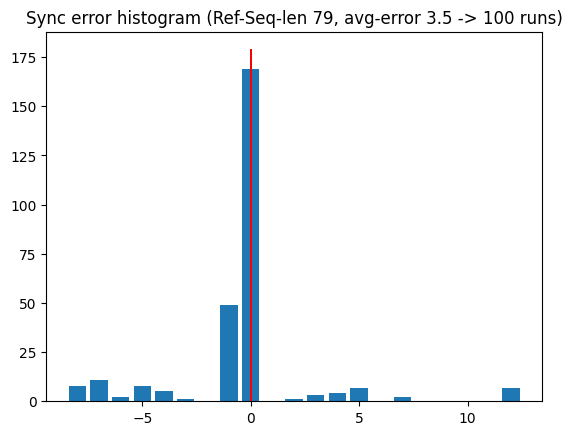

In [45]:
from matplotlib import pyplot as plt
plt.bar(tmp[12:] - tmp[np.argmax(counts)].item(), counts[12:])
plt.bar(0, np.max(counts) + 10, width=0.1, color="r")
plt.title("Sync error histogram 100 runs (Ref-Seq-len 79, avg-error 3.5)")